In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Parcelwise PLS chapman with age and gender regression

In [17]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ---------------------------------------------------
# SETTINGS
# ---------------------------------------------------
parcel_cols = [f'node_{i+1}' for i in range(400)]

# Clinical variables
clinical_vars = [
    'Hypomanic_scale',
    'Perceptual_aberration_scale',
    'Physical_anhedonia_scale',
    'Social_anhedonia_scale',
    'Hopkins_depression_scale'
]

# Cognitive domain definitions
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Covariates to regress out from brain data
covariate_cols = ['age', 'gender']

# Gradient files
gradient_files = {
    'G1': './g1_aligned_chap.csv',
    'G2': './g2_aligned_chap.csv',
    'G3': './g3_aligned_chap.csv'
}

# Initialize results dictionary
results = {}

# ---------------------------------------------------
# HELPER: Regress out covariates from brain data
# ---------------------------------------------------
def regress_out(X, covariates):
    """
    Regress out age/gender from each brain feature (column of X).
    X: n × p matrix (subjects × parcels)
    covariates: n × k matrix (e.g., age, gender)
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid

# ---------------------------------------------------
# LOOP OVER GRADIENTS
# ---------------------------------------------------
for grad_name, file_path in gradient_files.items():
    print(f"\n=== Processing {grad_name} ===")

    # Load gradient file
    df = pd.read_csv(file_path)

    # Encode gender numerically if needed
    if not np.issubdtype(df['gender'].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df['gender'].unique())}
        print(f"Auto-mapped 'gender': {mapping}")
        df['gender'] = df['gender'].map(mapping)

    # -------------------------------
    # Create cognitive domain scores
    # -------------------------------
    for group_name, var_list in group_definitions.items():
        missing = [v for v in var_list if v not in df.columns]
        if missing:
            raise KeyError(f"Missing cognitive variables for domain '{group_name}': {missing}")
        # Z-score each variable, invert so higher = worse
        zscored = df[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
        df[group_name] = -zscored.mean(axis=1)

    # -------------------------------
    # Extract imaging (X) and behavioral (Y)
    # -------------------------------
    X = df[parcel_cols].values
    Y_cols = clinical_vars + list(group_definitions.keys())
    Y = df[Y_cols].values

    # Remove subjects with missing data
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid = ~(nan_rows_X | nan_rows_Y)
    X_valid = X[valid]
    Y_valid = Y[valid]
    df_valid = df.loc[valid].copy()

    # -------------------------------
    # Regress out age and gender from X
    # -------------------------------
    covars = df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # -------------------------------
    # Standardize X and Y
    # -------------------------------
    X_std = StandardScaler().fit_transform(X_resid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # -------------------------------
    # Fit PLS (1 component)
    # -------------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Extract scores and saliences
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # -------------------------------
    # Compute behavioral correlations
    # -------------------------------
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        r, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = r

    # -------------------------------
    # Save results
    # -------------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid,
        'df_valid': df_valid,
        'X_std': X_std,
        'Y_std': Y_std
    }

    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"{grad_name} behavioral correlations (higher = worse):")
    for var, corr in behav_corrs.items():
        print(f"  {var:30s}: {corr:6.3f}")

print("\nAll gradients processed. Results stored in `results` dict.")



=== Processing G1 ===
G1 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.258
  Perceptual_aberration_scale   :  0.710
  Physical_anhedonia_scale      :  0.581
  Social_anhedonia_scale        :  0.601
  Hopkins_depression_scale      :  0.527
  Attention_WorkingMemory       :  0.647
  VerbalLearning_Memory         :  0.685
  Reasoning_ProblemSolving      :  0.607
  Verbal_Comprehension          :  0.608

=== Processing G2 ===
G2 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.303
  Perceptual_aberration_scale   :  0.728
  Physical_anhedonia_scale      :  0.546
  Social_anhedonia_scale        :  0.589
  Hopkins_depression_scale      :  0.512
  Attention_WorkingMemory       :  0.657
  VerbalLearning_Memory         :  0.658
  Reasoning_ProblemSolving      :  0.616
  Verbal_Comprehension          :  0.646

=== Processing G3 ===
G3 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.454
  Perceptual_aber

## Cortical projection

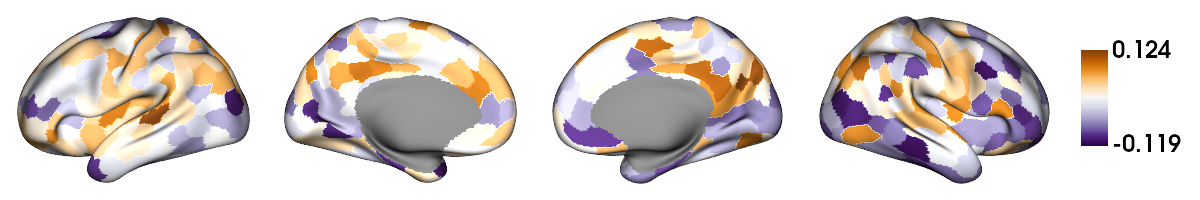

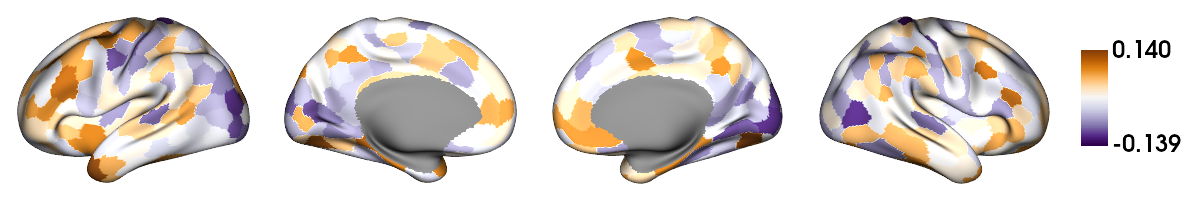

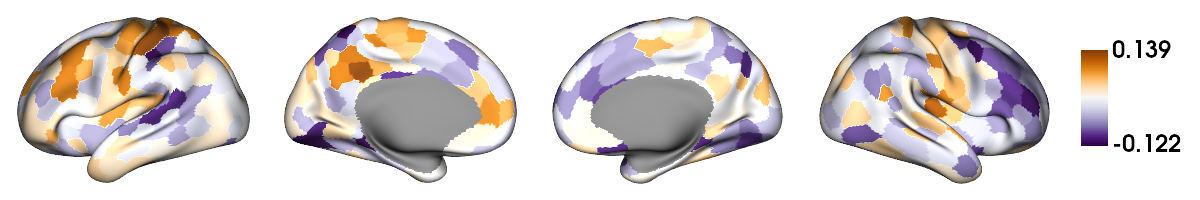

In [18]:
from IPython.display import Image, display
import numpy as np

for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']
    
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j+1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    filename = f'./new_figures/{grad_name}_LC1_map_cortex_chapman.png'
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # save instead of interactive window
        filename=filename
    )
    display(Image(filename))


## Permutation testing

In [19]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.2520
Permutation testing for G2...
G2 LV1 permutation p-value: 0.5351
Permutation testing for G3...
G3 LV1 permutation p-value: 0.5285


## Bootstrap resampling

Bootstrap resampling for G1...


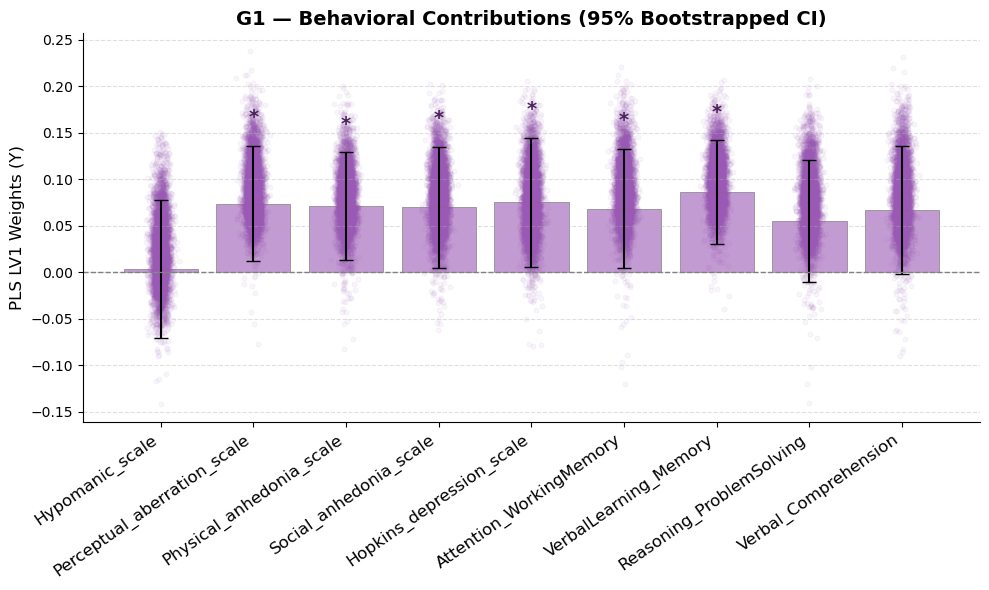

Bootstrap resampling for G2...


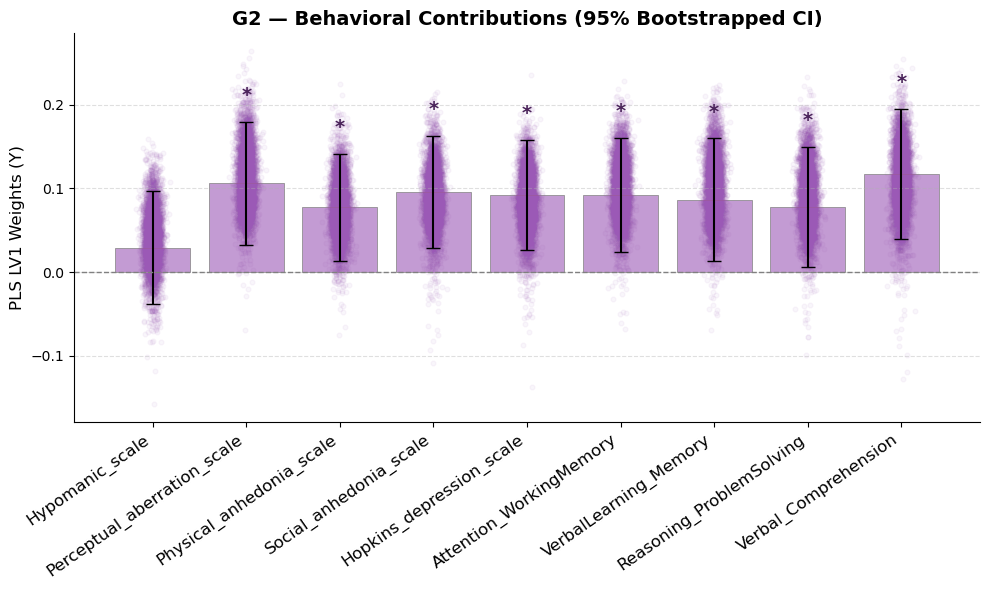

Bootstrap resampling for G3...


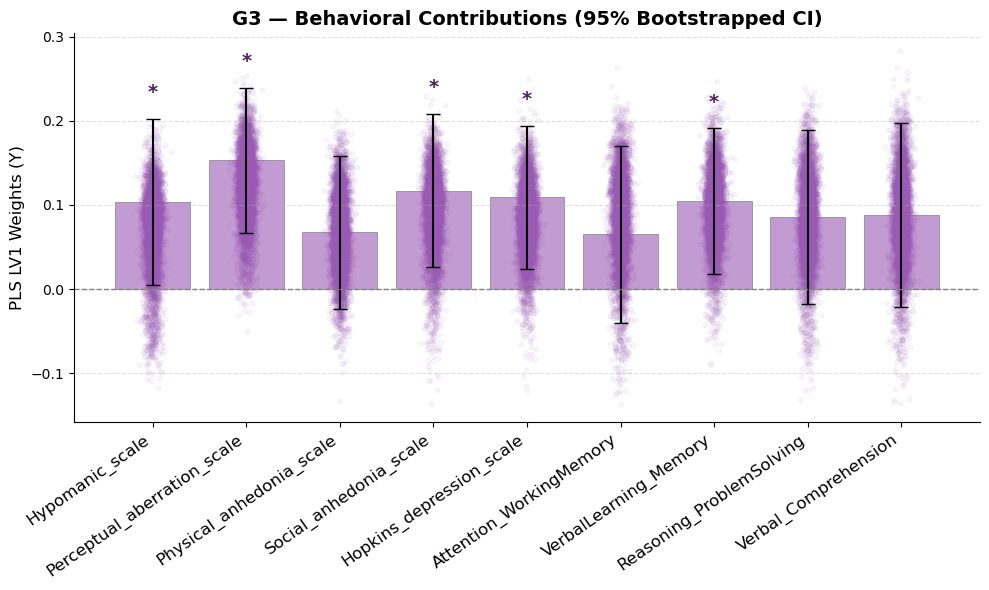

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting (purple theme)
bar_color = '#C39BD3'   # soft lavender
point_color = '#9B59B6' # medium purple
star_color = '#4A235A'  # deep plum (for text/stars)


# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------

        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1...
  LV1 explains 7.07% of X variance, 6.45% of Y variance, and 5.67% shared variance.

Computing variance explained for G2...
  LV1 explains 5.58% of X variance, 7.87% of Y variance, and 2.73% shared variance.

Computing variance explained for G3...
  LV1 explains 4.36% of X variance, 9.06% of Y variance, and 2.08% shared variance.



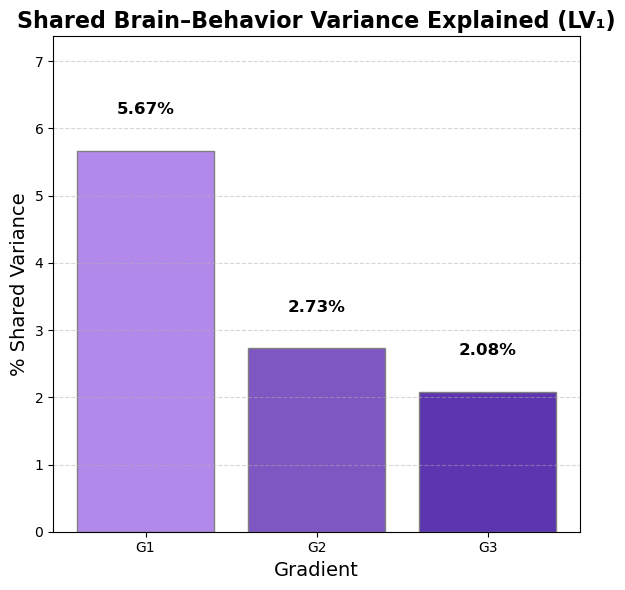

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict = {}

for grad_name, res in results.items():
    print(f"Computing variance explained for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Reconstruct predicted X and Y
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained within each block
    var_X = np.var(X, axis=0).sum()
    var_Y = np.var(Y, axis=0).sum()
    var_X_expl = np.var(X_pred, axis=0).sum() / var_X
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

    # Shared cross-covariance variance explained
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item() 

    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
grad_names = list(var_explained_dict.keys())
vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(
    grad_names,
    vals,
    color=['#B388EB', '#7E57C2', '#5E35B1'],  # light → medium → dark purple
    edgecolor='gray'
)


for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_chapman.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.050
  → Cross-validated correlation p-value = 0.2830

Cross-validating G2...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.042
  → Cross-validated correlation p-value = 0.2790

Cross-validating G3...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.026
  → Cross-validated correlation p-value = 0.3290


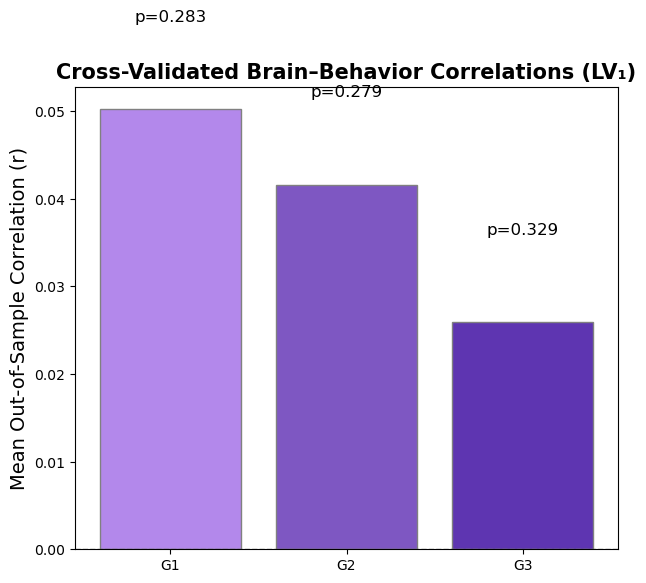

In [22]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 5        # for larger samples
n_repeats = 20      # number of random splits for KFold
n_perm = 1000       # number of permutations
random_state = 42

cv_results = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    # Choose CV strategy automatically
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        # LOOCV
        for test_idx in range(n):
            train_idx = np.setdiff1d(np.arange(n), test_idx)
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])

            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))

        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        # Average across repeats
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs = []
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs.append(r_perm)

    perm_corrs = np.array(perm_corrs)
    pval = np.mean(perm_corrs >= observed_r)

    cv_results[grad_name] = {
        'observed_r': observed_r,
        'perm_corrs': perm_corrs,
        'pval': pval
    }

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results.keys(),
               [cv_results[g]['observed_r'] for g in cv_results],
               color=['#B388EB', '#7E57C2', '#5E35B1'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]['observed_r']
    p = cv_results[g]['pval']
    plt.text(i, r + 0.01, f"p={p:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.savefig("new_figures/cv_out_of_sample_correlations_chapman.png", dpi=300)
plt.show()


## Split half resampling

In [23]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits = 100  # number of random split-half resamplings
stability_results = {}

for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split
        idx = np.random.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlation
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    stability_results[grad_name] = {
        'brain_stability': np.mean(brain_corrs),
        'behav_stability': np.mean(behav_corrs),
        'brain_corrs_all': brain_corrs,
        'behav_corrs_all': behav_corrs
    }

    print(f"  Brain pattern stability (mean r): {stability_results[grad_name]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results[grad_name]['behav_stability']:.3f}")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.133
  Behavioral pattern stability (mean r): 0.178

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.072
  Behavioral pattern stability (mean r): -0.115

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.083
  Behavioral pattern stability (mean r): -0.039


# Parcelwise PLS chapman without age and gender regression

In [24]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from IPython.display import Image, display

# ---------------------------------------------------
# SETTINGS
# ---------------------------------------------------
parcel_cols = [f'node_{i+1}' for i in range(400)]

# Clinical + demographic variables (age & gender are kept here)
clinical_vars = [
    'Hypomanic_scale',
    'Perceptual_aberration_scale',
    'Physical_anhedonia_scale',
    'Social_anhedonia_scale',
    'Hopkins_depression_scale',
    'age',
    'gender'
]

# Cognitive domain definitions
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

gradient_files = {
    'G1': './g1_aligned_chap.csv',
    'G2': './g2_aligned_chap.csv',
    'G3': './g3_aligned_chap.csv'
}

results = {}

# ---------------------------------------------------
# LOOP OVER GRADIENTS
# ---------------------------------------------------
for grad_name, file_path in gradient_files.items():
    print(f"\n=== Processing {grad_name} ===")

    df = pd.read_csv(file_path)

    # Encode gender numerically if needed
    if not np.issubdtype(df['gender'].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df['gender'].unique())}
        print(f"Auto-mapped 'gender': {mapping}")
        df['gender'] = df['gender'].map(mapping)

    # -------------------------------
    # Create cognitive domain scores
    # -------------------------------
    for domain, vars_list in group_definitions.items():
        missing = [v for v in vars_list if v not in df.columns]
        if missing:
            raise KeyError(f"Missing cognitive vars for domain '{domain}': {missing}")
        # Z-score each variable and average; invert so higher = worse
        zscored = df[vars_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
        df[domain] = -zscored.mean(axis=1)

    # -------------------------------
    # Extract X and Y matrices
    # -------------------------------
    X = df[parcel_cols].values
    Y_cols = clinical_vars + list(group_definitions.keys())  # include cognitive domains
    Y = df[Y_cols].values

    # -------------------------------
    # Drop subjects with missing data
    # -------------------------------
    valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(Y).any(axis=1))
    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    df_valid = df.loc[valid_mask].copy()

    # -------------------------------
    # Standardize X and Y
    # -------------------------------
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # -------------------------------
    # Fit PLS (1 component)
    # -------------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # -------------------------------
    # Compute behavioral correlations
    # -------------------------------
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        r, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = r

    # -------------------------------
    # Save results
    # -------------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'df_valid': df_valid,
        'X_std': X_std,
        'Y_std': Y_std
    }

    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:30s}: {corr:6.3f}")

print("\nAll gradients processed (ALL participants). Results stored in `results` dict.")



=== Processing G1 ===
G1 behavioral correlations (higher = worse severity):
  Hypomanic_scale               : -0.194
  Perceptual_aberration_scale   : -0.627
  Physical_anhedonia_scale      : -0.495
  Social_anhedonia_scale        : -0.514
  Hopkins_depression_scale      : -0.421
  age                           : -0.480
  gender                        :  0.287
  Attention_WorkingMemory       : -0.691
  VerbalLearning_Memory         : -0.726
  Reasoning_ProblemSolving      : -0.702
  Verbal_Comprehension          : -0.599

=== Processing G2 ===
G2 behavioral correlations (higher = worse severity):
  Hypomanic_scale               : -0.265
  Perceptual_aberration_scale   : -0.658
  Physical_anhedonia_scale      : -0.492
  Social_anhedonia_scale        : -0.533
  Hopkins_depression_scale      : -0.442
  age                           : -0.448
  gender                        :  0.303
  Attention_WorkingMemory       : -0.681
  VerbalLearning_Memory         : -0.705
  Reasoning_ProblemSolving

## Cortical projection

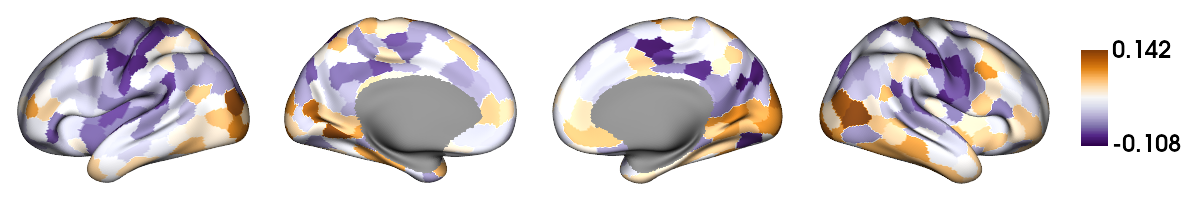

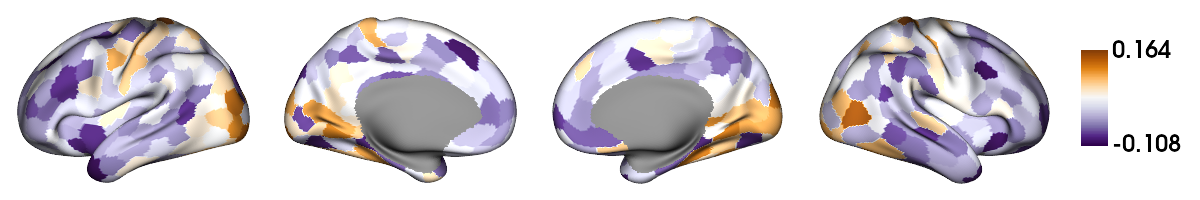

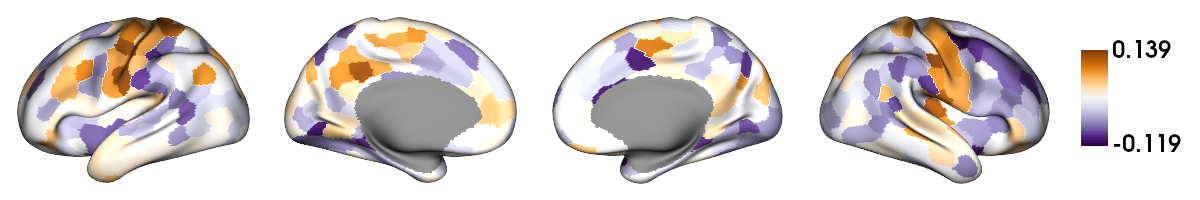

In [25]:
from IPython.display import Image, display
import numpy as np

for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']
    
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j+1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    filename = f'./new_figures/{grad_name}_LC1_map_cortex_chapman_noreg.png'
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # save instead of interactive window
        filename=filename
    )
    display(Image(filename))


## Permutation testing

In [26]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.0278
Permutation testing for G2...
G2 LV1 permutation p-value: 0.1220
Permutation testing for G3...
G3 LV1 permutation p-value: 0.1157


## Bootstrap resampling

Bootstrap resampling for G1...


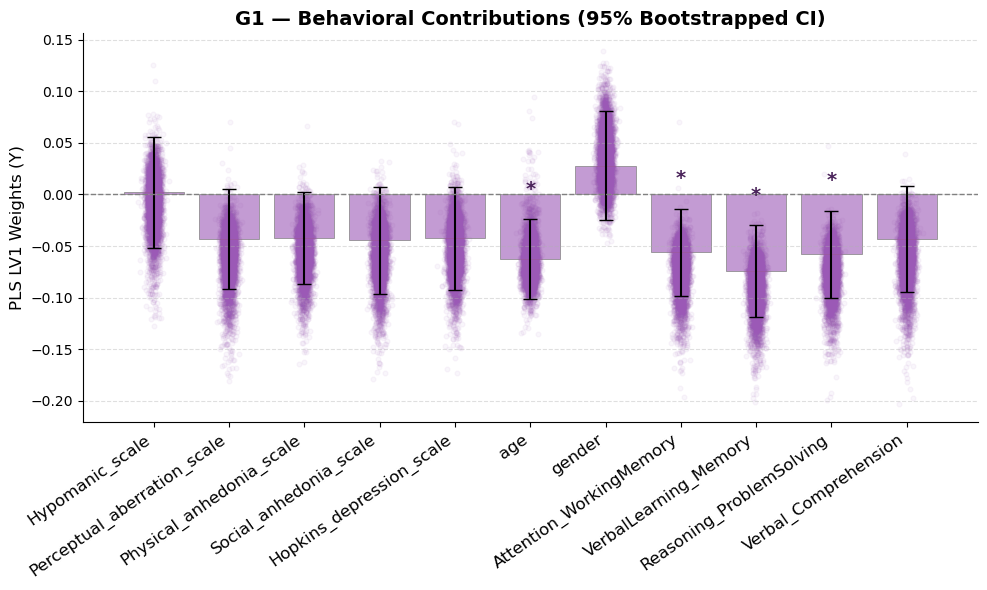

Bootstrap resampling for G2...


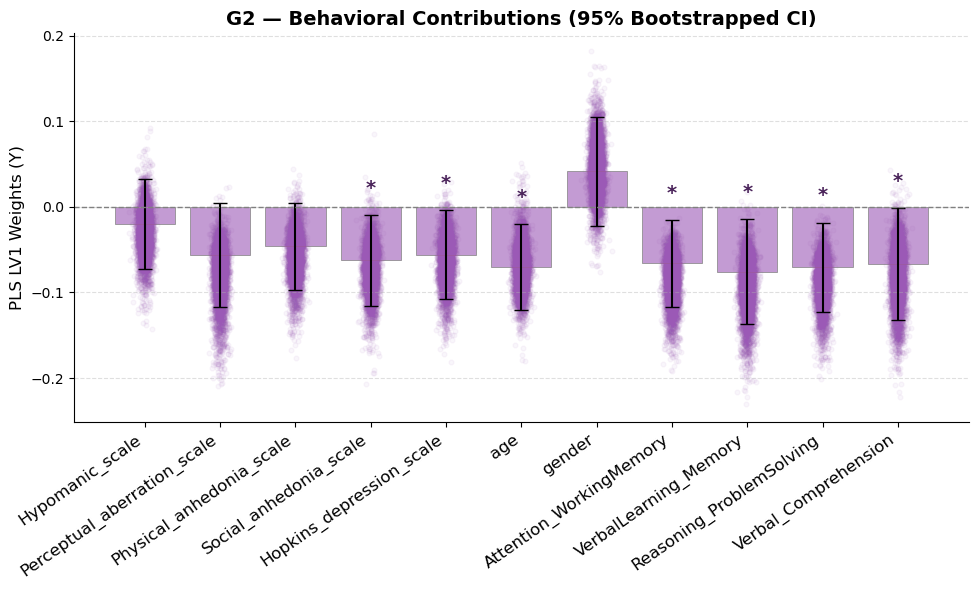

Bootstrap resampling for G3...


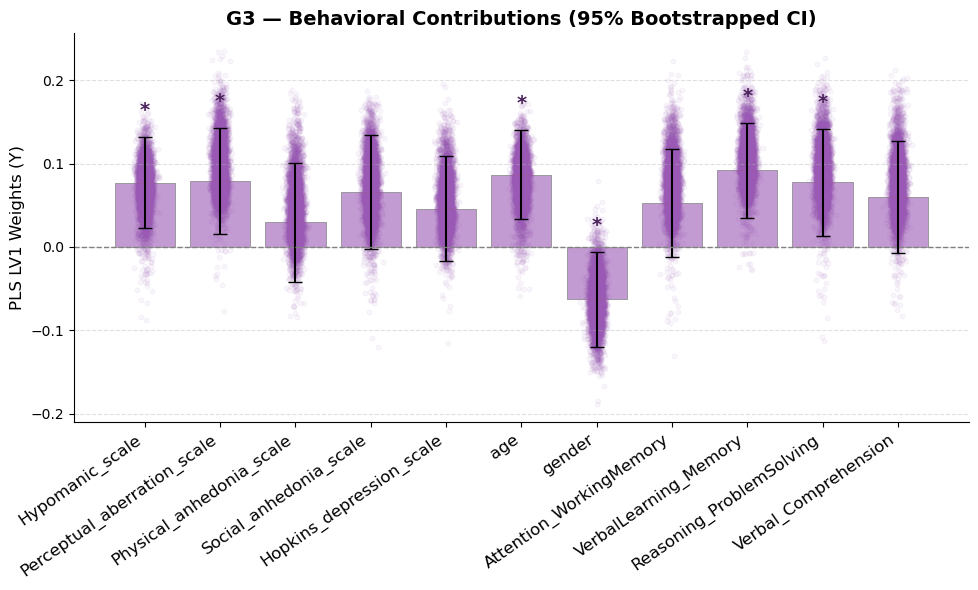

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting (purple theme)
bar_color = '#C39BD3'   # soft lavender
point_color = '#9B59B6' # medium purple
star_color = '#4A235A'  # deep plum (for text/stars)


# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------

        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1...
  LV1 explains 8.53% of X variance, 5.39% of Y variance, and 11.79% shared variance.

Computing variance explained for G2...
  LV1 explains 7.31% of X variance, 5.99% of Y variance, and 6.50% shared variance.

Computing variance explained for G3...
  LV1 explains 6.52% of X variance, 7.22% of Y variance, and 5.28% shared variance.



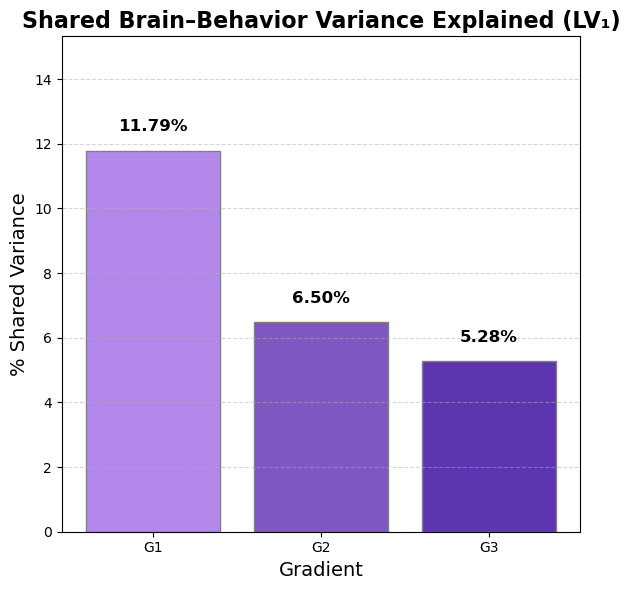

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict = {}

for grad_name, res in results.items():
    print(f"Computing variance explained for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Reconstruct predicted X and Y
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained within each block
    var_X = np.var(X, axis=0).sum()
    var_Y = np.var(Y, axis=0).sum()
    var_X_expl = np.var(X_pred, axis=0).sum() / var_X
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

    # Shared cross-covariance variance explained
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item() 

    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
grad_names = list(var_explained_dict.keys())
vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(
    grad_names,
    vals,
    color=['#B388EB', '#7E57C2', '#5E35B1'],  # light → medium → dark purple
    edgecolor='gray'
)


for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_chapman.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.226
  → Cross-validated correlation p-value = 0.0140

Cross-validating G2...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.138
  → Cross-validated correlation p-value = 0.0940

Cross-validating G3...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.248
  → Cross-validated correlation p-value = 0.0130


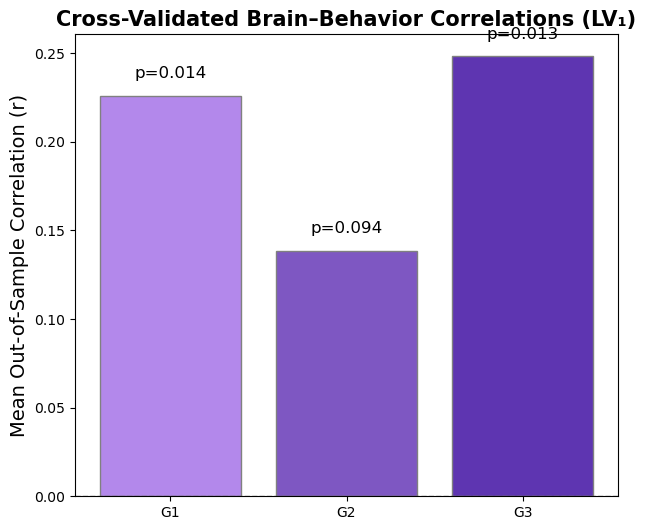

In [29]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 5        # for larger samples
n_repeats = 20      # number of random splits for KFold
n_perm = 1000       # number of permutations
random_state = 42

cv_results = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    # Choose CV strategy automatically
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        # LOOCV
        for test_idx in range(n):
            train_idx = np.setdiff1d(np.arange(n), test_idx)
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])

            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))

        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        # Average across repeats
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs = []
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs.append(r_perm)

    perm_corrs = np.array(perm_corrs)
    pval = np.mean(perm_corrs >= observed_r)

    cv_results[grad_name] = {
        'observed_r': observed_r,
        'perm_corrs': perm_corrs,
        'pval': pval
    }

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results.keys(),
               [cv_results[g]['observed_r'] for g in cv_results],
               color=['#B388EB', '#7E57C2', '#5E35B1'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]['observed_r']
    p = cv_results[g]['pval']
    plt.text(i, r + 0.01, f"p={p:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.savefig("new_figures/cv_out_of_sample_correlations_chapman.png", dpi=300)
plt.show()


## Split half resampling

In [30]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits = 100  # number of random split-half resamplings
stability_results = {}

for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split
        idx = np.random.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlation
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    stability_results[grad_name] = {
        'brain_stability': np.mean(brain_corrs),
        'behav_stability': np.mean(behav_corrs),
        'brain_corrs_all': brain_corrs,
        'behav_corrs_all': behav_corrs
    }

    print(f"  Brain pattern stability (mean r): {stability_results[grad_name]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results[grad_name]['behav_stability']:.3f}")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.319
  Behavioral pattern stability (mean r): 0.717

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.224
  Behavioral pattern stability (mean r): 0.667

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.296
  Behavioral pattern stability (mean r): 0.731
